## Imports

In [1]:
# Set GPUs to use
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=4

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=4


In [3]:
# Standard data science imports
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.io import imsave
import h5py
import rasterio

# Import class to split image into smaller tiles from 
# https://github.com/ESA-PhiLab/eo4ai/tree/master/eo4ai/utils
# Courtesy of Alistair Francis and John Mrziglod
from splitters import * 

# Tensorflow and Keras
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Set Directories

In [4]:
# INPUT
vv_path = r'/home/stewartchris/project/S1/data/Egypt_S1_S0_TC_stack_mean_dB_VV.tif'
vh_path = r'/home/stewartchris/project/S1/data/Egypt_S1_S0_TC_stack_mean_dB_VH.tif'
coh_path = r'/home/stewartchris/project/S1/data/Egypt_S1_coh_TC_mean.tif'
mask_path = r'/home/stewartchris/project/S1/data/Egypt_mask.tif'

#pol_paths = [pol2_path, pol3_path]
#mask_paths = [mask2_path, mask3_path]

# OUTPUT
model_path = r'/home/stewartchris/project/S1/models/Model_Egypt3channels_ep100_spe50_lr0001_bs16.h5'
pred_path = r'/home/stewartchris/project/S1/data/prediction_Egypt3channels_ep100_spe50_lr0001_bs16.tif'
train_acc_path = r'/home/stewartchris/project/S1/data/Accuracy_Egypt3channels_ep100_spe50_lr0001_bs16_val100.png'
train_loss_path = r'/home/stewartchris/project/S1/data/Loss_Egypt3channels_ep100_spe50_lr0001_bs16_val100.png'
data_aug_path = r'/home/stewartchris/project/S1/data/TEMPEgypt3channels_data_aug.png'
data_aug_SAR_path = r'/home/stewartchris/project/S1/data/TEMPEgypt3channels_data_aug_SAR.png'
data_aug_mask_path = r'/home/stewartchris/project/S1/data/TEMPEgypt3channels_data_aug_mask.png'

## Read Data

#### Set window size
Dimensions of patch for segmentation

In [5]:
window = 256

### To extract intensity & coherence

In [6]:
vv_orig = imread(vv_path, key=0)
vh_orig = imread(vh_path, key=0)
coh_orig = imread(coh_path, key=0)
mask_orig = imread(mask_path, key=0)

In [7]:
# merge polarimetric and coherence channels into rgb
band_orig = np.zeros((vv_orig.shape[0],vv_orig.shape[1],3))
band_orig[:,:,0] = vv_orig
band_orig[:,:,1] = vh_orig
band_orig[:,:,2] = coh_orig

## Preprocess Data

#### Split image into smaller patches

In [8]:
# apply sliding window splitter, need to import splitter.py from 
# https://github.com/ESA-PhiLab/eo4ai/tree/master/eo4ai/utils

mask_3d = mask_orig[..., np.newaxis]
splitter = SlidingWindowSplitter(window, window) # from splitter.py
bands_patches, mask_patches, patch_ids = splitter(band_orig, mask_3d)

bpatches = np.array(bands_patches)
mpatches = np.array(mask_patches)
ipatches = np.array(patch_ids)

#### Filter patches

##### Remove patches beyond edges of intensity (where 0)

In [9]:
# Sum values for three channels (i.e. VV + VH + Coh)
bpatchesSum = np.sum(bpatches[...,0:1], axis=3) # FOR THREE CHANNELS
#bpatchesSum = bpatches[...,0] # FOR TWO CHANNELS
#bpatchesSum = np.sum(bpatches, axis=3) # FOR ONE CHANNEL ONLY

# Test whether all array elements along axes 1 & 2 (rows/cols) evaluate to True (i.e. non-zero).
zeroTest = np.all(bpatchesSum, axis=(1,2))

# Extract indices of all non-zero patches
indices = np.where(zeroTest == True)
indices = indices[0]
sents = bpatches[indices, ...]
masks = mpatches[indices, ...]
ids = ipatches[indices, ...]

##### Remove patches beyond edges of coherence (where nan)

In [10]:
# Test whether values are nan in Coh (nan is True)
indices_nan_boolean = np.isnan(sents[...,2])
#indices_nan_boolean = np.isnan(sents[...,1]) # FOR COHERENCE ONLY

# Test whether any array element along axes 1 & 2 (rows/cols) evaluate to True (i.e. nan).
nanTest = np.any(indices_nan_boolean, axis=(1,2))

# Extract indices of patches that do not contain any nan
indices = np.where(nanTest == False)
indices = indices[0]
sents = sents[indices, ...]
masks = masks[indices, ...]
ids = ids[indices, ...]

##### Remove patches where no Open Street Map

In [11]:
masksFlat = masks.reshape((masks.shape[0]), window*window)
index = np.where(np.sum(masksFlat, axis=1) > 0)
index = np.squeeze(np.array(index))

sents = sents[index, ...]
masks = masks[index, ...]
ids = ids[index, ...]

#### Normalise data

In [12]:
# normalise data from dB to range(0, 1)
sentsMin = np.amin(sents, axis=(0,1,2))
sentsMax = np.amax(sents, axis=(0,1,2))
sents = (sents - sentsMin) / (sentsMax - sentsMin)

In [32]:
print('The number of samples are:', sents.shape[0])

The number of samples are: 449


#### Train / Validate / Test split

In [34]:
# split train and test data

random_indices = np.arange(sents.shape[0])
np.random.shuffle(random_indices)
sentshuf = sents[random_indices, ...]
maskshuf = masks[random_indices, ...]
idshuf = ids[random_indices, ...]

train_size = 329
val_size = 100

sentTrain = sentshuf[:train_size, ...]
maskTrain = maskshuf[:train_size, ...]
idsTrain = idshuf[:train_size, ...]

sentVal = sentshuf[train_size:(train_size + val_size), ...]
maskVal = maskshuf[train_size:(train_size + val_size), ...]
idsVal = idshuf[train_size:(train_size + val_size), ...]

sentTest = sentshuf[(train_size + val_size):, ...]
maskTest = maskshuf[(train_size + val_size):, ...]
idsTest = idshuf[(train_size + val_size):, ...]

#### No Train / Validate / Test split (use all data for better training)

In [13]:
random_indices = np.arange(sents.shape[0])
np.random.shuffle(random_indices)
sentTrain = sents[random_indices, ...]
maskTrain = masks[random_indices, ...]
idsTrain = ids[random_indices, ...]

## Data Augmentation

In [20]:
data_gen_args = dict(
    rotation_range=360,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fill modes:
#'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
#'nearest': aaaaaaaa|abcd|dddddddd
#'reflect': abcddcba|abcd|dcbaabcd
#'wrap': abcdabcd|abcd|abcdabcd

### Visualise Augmented Data

In [21]:
from numpy import expand_dims

#### View original image and mask

In [32]:
index_to_view = 3

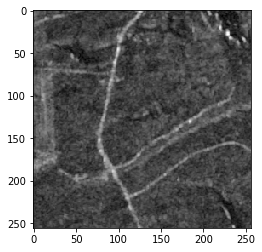

In [33]:
# Use this if multi band image
plt.imshow(sentTrain[index_to_view,:,:,0], cmap='gray')
# Use this if one band image
#plt.imshow(np.squeeze(sentTrain[index_to_view]), cmap='gray')
#plt.savefig(data_aug_SAR_path, dpi=300)

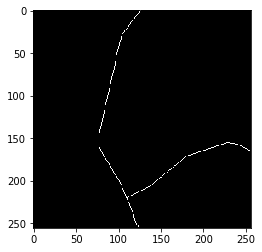

In [34]:
plt.imshow(np.squeeze(maskTrain[index_to_view]), cmap='gray')
#plt.savefig(data_aug_mask_path, dpi=300)

#### View augmented images, applied to original

In [35]:
Ss = expand_dims(sentTrain[index_to_view],0)
Ms = expand_dims(maskTrain[index_to_view],0)

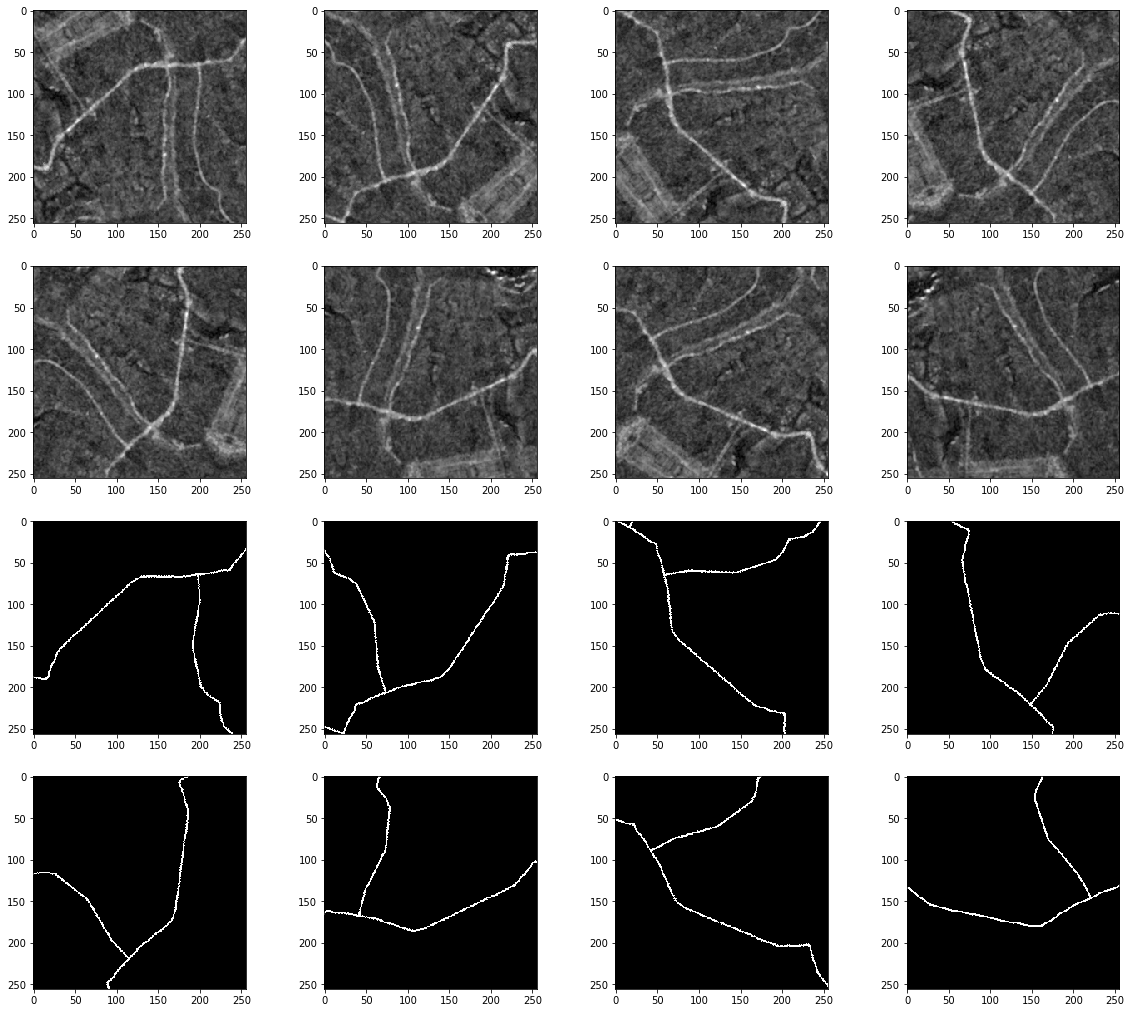

In [36]:
datagen = ImageDataGenerator(rotation_range=360, horizontal_flip=True, vertical_flip=True, fill_mode='reflect')
Sa = datagen.flow(Ss, batch_size=1, seed=1)
Ma = datagen.flow(Ms, batch_size=1, seed=1)

plt.figure(figsize=(20, 18))
for i in range(8):
    plt.subplot(4,4,1 + i)
    Sa_batch = Sa.next()
    plt.imshow(np.squeeze(Sa_batch[...,0]), cmap='gray')
    plt.subplot(4,4,1 + i+8)
    Ma_batch = Ma.next()
    Ma_batch[Ma_batch > 0] = 1
    Ma_batch = Ma_batch.astype(bool)
    plt.imshow(np.squeeze(Ma_batch), cmap='gray')
#plt.savefig(data_aug_path, dpi=300)

## Define Hyperparameters and Data Generators

In [47]:
# Hyperparameters
EPOCHS = 100
STEPS_PER_EPOCH = 50
LEARNING_RATE = 0.0001
BATCH_SIZE = 16

In [48]:
def trainGenerator(batch_size, train_data, mask_data, aug_dict, seed):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow(train_data, batch_size = batch_size, seed = seed)
    mask_generator = mask_datagen.flow(mask_data, batch_size = batch_size, seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mas) in train_generator:
        mas[mas > 0] = 1
        mas = mas.astype(bool)
        yield (img,mas)

In [49]:
trainGene = trainGenerator(BATCH_SIZE, sentTrain, maskTrain, data_gen_args, 1)

In [50]:
def valGenerator(batch_size, val_data, val_mask_data, seed):
    image_generator = ImageDataGenerator().flow(val_data, batch_size = batch_size, seed = seed)
    mask_generator = ImageDataGenerator().flow(val_mask_data, batch_size = batch_size, seed = seed)
    val_generator = zip(image_generator, mask_generator)
    for (img,mas) in val_generator:
        mas[mas > 0] = 1
        mas = mas.astype(bool)
        yield (img,mas)

In [51]:
valGene = valGenerator(1, sentVal, maskVal, 1)

## Define U-Net Deep Learning Model for Image Segmentation

In [52]:
# define accuracy metric
# Code taken from https://github.com/Paulymorphous/Road-Segmentation/blob/master/Src/Road_Detection_GPU.ipynb
# Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
# Courtesy of Jerin Paul 
from tensorflow.keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
  return iou

In [53]:
# define loss function
# Code taken from https://github.com/Paulymorphous/Road-Segmentation/blob/master/Src/Road_Detection_GPU.ipynb
# Courtesy of Jerin Paul 
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [54]:
# define U-Net model
# Code taken from https://github.com/Paulymorphous/Road-Segmentation/blob/master/Src/Road_Detection_GPU.ipynb
# Courtesy of Jerin Paul
inputs = Input((window, window, 3))

conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

W0525 17:35:26.118182 139835978544640 deprecation.py:506] From /home/stewartchris/project/pythonvirtualenv/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1633: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [55]:
# Compile the model
opt = tf.keras.optimizers.Adam(LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef])

## Model Training

### With Data Augmentation

##### With Data Augmentation and Validation Steps

In [56]:
# Train the model with data augmentation
history = model.fit_generator(
    trainGene, 
    steps_per_epoch=STEPS_PER_EPOCH, 
    epochs=EPOCHS,
    validation_data=valGene,
    validation_steps=sentVal.shape[0]
)

Epoch 1/100


W0525 17:35:56.393511 139835978544640 deprecation.py:323] From /home/stewartchris/project/pythonvirtualenv/lib/python3.7/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


50/50 [==============================] - 20s 407ms/step - loss: 0.9421 - iou_coef: 0.0320 - val_loss: 0.9714 - val_iou_coef: 0.0146
Epoch 2/100
50/50 [==============================] - 15s 290ms/step - loss: 0.9302 - iou_coef: 0.0403 - val_loss: 0.9690 - val_iou_coef: 0.0160
Epoch 3/100
50/50 [==============================] - 15s 304ms/step - loss: 0.9216 - iou_coef: 0.0469 - val_loss: 0.9746 - val_iou_coef: 0.0130
Epoch 4/100
50/50 [==============================] - 15s 301ms/step - loss: 0.9147 - iou_coef: 0.0521 - val_loss: 0.9761 - val_iou_coef: 0.0122
Epoch 5/100
50/50 [==============================] - 15s 304ms/step - loss: 0.9076 - iou_coef: 0.0562 - val_loss: 0.9584 - val_iou_coef: 0.0217
Epoch 6/100
50/50 [==============================] - 15s 300ms/step - loss: 0.9025 - iou_coef: 0.0602 - val_loss: 0.9647 - val_iou_coef: 0.0183
Epoch 7/100
50/50 [==============================] - 15s 305ms/step - loss: 0.8955 - iou_coef: 0.0654 - val_loss: 0.9371 - val_iou_coef: 0.0344
Epoc

##### With Data Augmentation but no Validation

In [ ]:
# Train the model with data augmentation
history = model.fit_generator(
    trainGene, 
    steps_per_epoch=STEPS_PER_EPOCH, 
    epochs=EPOCHS,
)

In [59]:
# Save the trained and compiled model to a file
model.save(model_path)

## Check model performance during training

In [60]:
print(history.history.keys())

dict_keys(['loss', 'iou_coef', 'val_loss', 'val_iou_coef'])


In [61]:
jac = history.history['iou_coef']
val_jac = history.history['val_iou_coef']
loss = history.history['loss']
val_loss = history.history['val_loss']

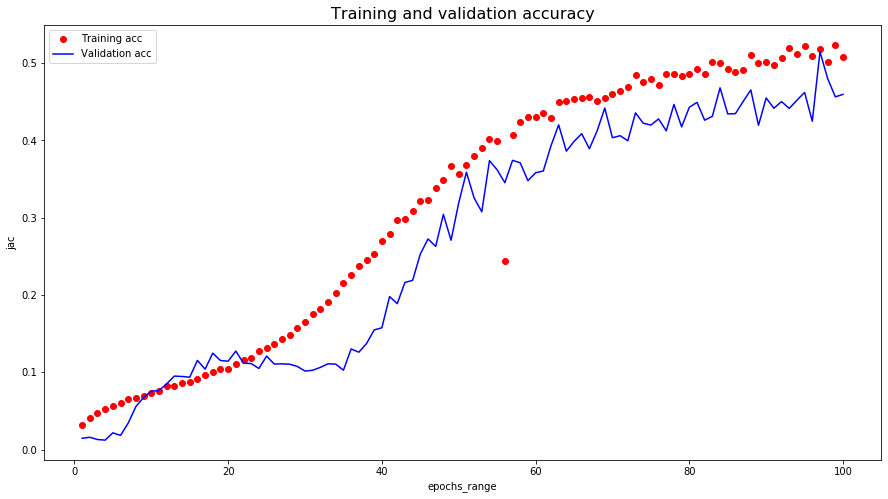

In [62]:
epochs_range = range(1, len(jac) + 1)
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(epochs_range, jac, 'bo', c='red', label='Training acc')
ax.plot(epochs_range, val_jac, 'b', c='blue', label='Validation acc')
ax.set_title('Training and validation accuracy', fontsize=16)
ax.set_xlabel('epochs_range')
ax.set_ylabel('jac')
ax.legend()
plt.savefig(train_acc_path, dpi=300)

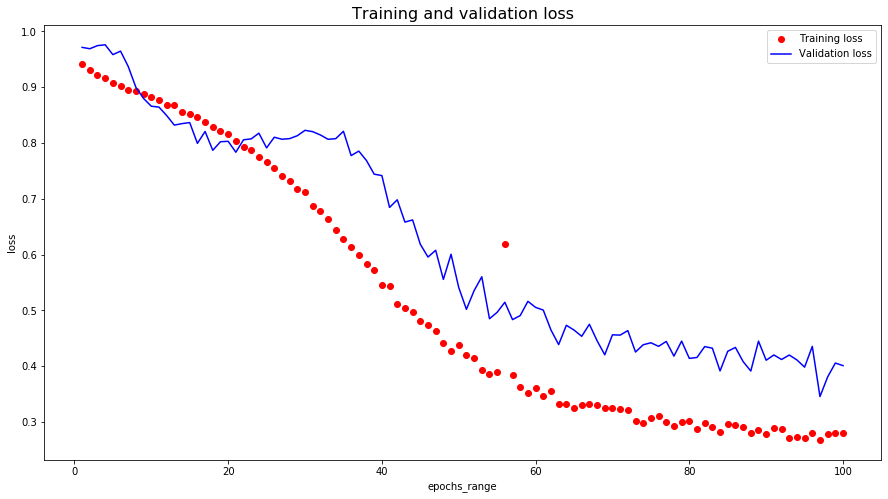

In [63]:
epochs_range = range(1, len(jac) + 1)
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(epochs_range, loss, 'bo', c='red', label='Training loss')
ax.plot(epochs_range, val_loss, 'b', c='blue', label='Validation loss')
ax.set_title('Training and validation loss', fontsize=16)
ax.set_xlabel('epochs_range')
ax.set_ylabel('loss')
ax.legend()
plt.savefig(train_loss_path, dpi=300)

#### Check accuracy with test data

In [64]:
# Evaluate performance of VH,VV,Coh trained model on test data
results = model.evaluate(sentTest, maskTest)

20/20 [==============================] - 1s 25ms/sample - loss: 0.3202 - iou_coef: 0.4734


## Apply model

In [14]:
model = load_model(model_path, compile=False)

W0508 19:08:34.620963 140188768634368 deprecation.py:506] From /home/stewartchris/project/pythonvirtualenv/lib/python3.7/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0508 19:08:34.623032 140188768634368 deprecation.py:506] From /home/stewartchris/project/pythonvirtualenv/lib/python3.7/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0508 19:08:34.627544 140188768634368 deprecation.py:506] From /home/stewartchris/project/pythonvirtualenv/lib/python3.7/site-packages/tensorflo

In [239]:
# Apply model to new data
prediction = model.predict(sents, verbose=1)

4111/4111 [==============================] - 9s 2ms/sample


In [240]:
# convert deep learning output to boolean mask
prediction[prediction >= 0.5] = 1
prediction[prediction < 0.5] = 0
maskPred = prediction.astype(bool)

#### Reconstruct image from patches

In [241]:
# replace original mask patches with predicted patches (i.e. to recreate 
# rectangular image, with no data padding around vector cutline)
indboo = np.isin(ipatches, ids) # boolean index
indnor = np.where(indboo == True) # normal index
mpatches_pred = mpatches.copy()
mpatches_pred[indnor,...] = prediction

In [242]:
# function to reconstruct image from patches
def reconstruct(orig2d, patches3d, window):
    n_x = (orig2d.shape[0] - window) // window + 1
    n_y = (orig2d.shape[1] - window) // window + 1
    reconstructed = np.zeros([n_x*window, n_y*window])
    for i in range(n_x):
        for j in range(n_y):
            reconstructed[i*window:(i+1)*window, j*window:(j+1)*window] = patches3d[j+(i*n_y), ...]
    recon_orig_size = np.zeros(orig2d.shape)
    recon_orig_size[:reconstructed.shape[0], :reconstructed.shape[1]] = reconstructed
    return recon_orig_size

In [243]:
# ensure prediction has correct dimension and apply function to reconstruct image from patches
pred3d = np.squeeze(mpatches_pred)
recon_orig_size = reconstruct(mask_orig, pred3d, window)

#### Save output

In [244]:
# Save output to image

with rasterio.open(mask_path) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=1)

with rasterio.open(pred_path, 'w', **profile) as dst:
    dst.write(recon_orig_size.astype(rasterio.float32), 1)

## Other Code

#### To extract training data from multiple images

In [ ]:
# declare sliding window splitter class, need to import splitter.py from 
# https://github.com/ESA-PhiLab/eo4ai/tree/master/eo4ai/utils
splitter = SlidingWindowSplitter(window, window)

# read data
def read_data():
    bpatches = np.empty((0, window, window, 1))
    mpatches = np.empty((0, window, window, 1))
    ipatches = np.empty((0))
    for pol, mask in zip(pol_paths, mask_paths):
        pol_orig = imread(pol, key=0)
        if pol_orig.ndim == 3:
            band_orig = np.zeros((pol_orig.shape[0],pol_orig.shape[1],pol_orig.shape[2]-1))
            band_orig[...,0] = pol_orig[...,1] # for Egypt, pol_orig[...,0] = VH, pol_orig[...,1] = VV
        elif pol_orig.ndim == 2:
            band_orig = np.zeros((pol_orig.shape[0],pol_orig.shape[1]))
            band_orig[...] = pol_orig
            band_orig = band_orig[..., np.newaxis]
        mask_orig = imread(mask, key=0)
        mask_orig = mask_orig[..., np.newaxis]
        
        bands_patches, mask_patches, patch_ids = splitter(band_orig, mask_orig)
        
        bpatches = np.append(bpatches, np.array(bands_patches), axis = 0)
        mpatches = np.append(mpatches, np.array(mask_patches), axis = 0)
        ipatches = np.append(ipatches, np.array(patch_ids), axis = 0)
    return bpatches, mpatches, ipatches

bpatches, mpatches, ipatches = read_data()